### This notebook includes the pre-processing that is performed before the segmentation of the lungs.

In [1]:
# Import Libraries
import os
from pathlib import Path
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from utils_c import *
from skimage import measure
import re
import cv2 as cv

In [2]:
# Check the histograms of the images
# img = sitk.ReadImage('../data/nifti/copd1_eBHCT.nii.gz')
# img_array = sitk.GetArrayFromImage(img)
# img_array.shape # they are 3d grayscale images
# print(f"maximum intensity value: {np.max(img_array)}, minimum intensity value: {np.min(img_array)}")

def info_images(patient, type):
    img = sitk.ReadImage(f'../data/nifti/copd{patient}_{type}BHCT.nii.gz')
    img_array = sitk.GetArrayFromImage(img)
    print(f"maximum intensity value: {np.max(img_array)}, minimum intensity value: {np.min(img_array)}")

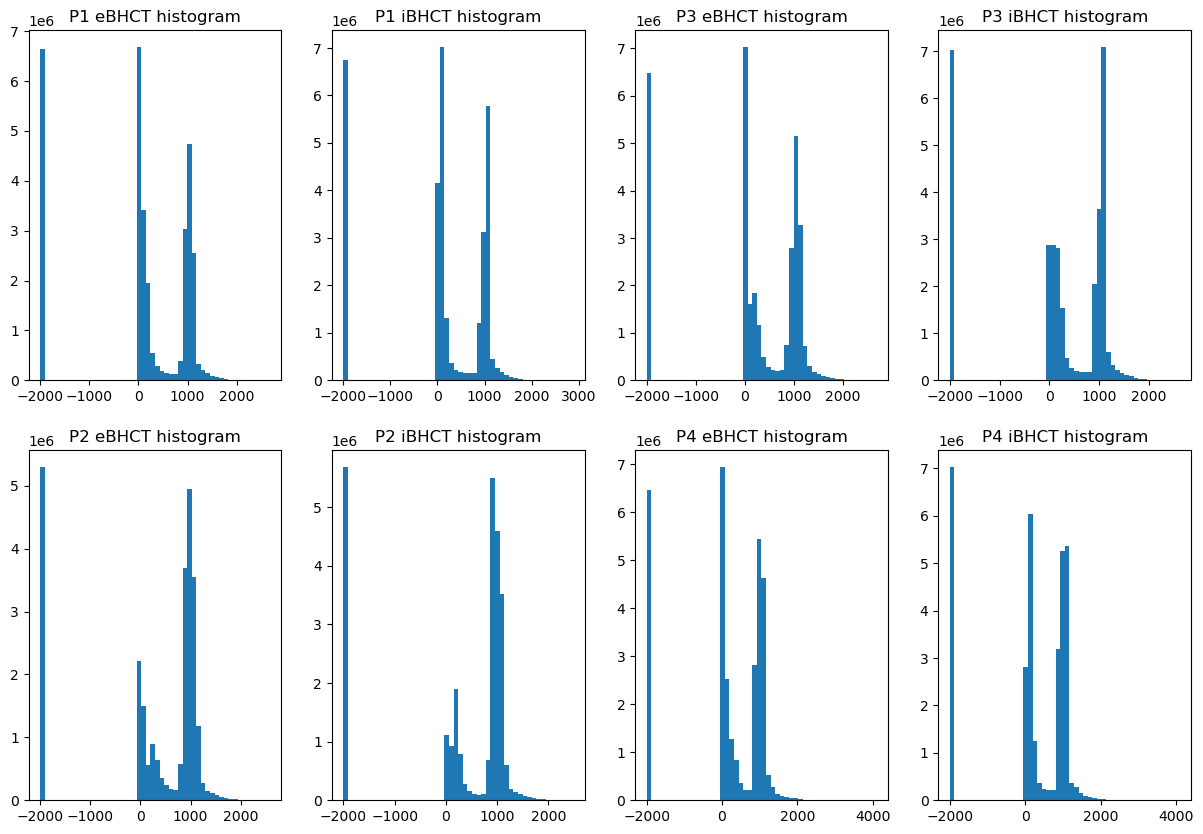

In [3]:
# make subplots
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
axs[0, 0].hist(sitk.GetArrayFromImage(sitk.ReadImage('../data/nifti/copd1_eBHCT.nii.gz')).flatten(), bins=50)  
axs[0, 0].set_title('P1 eBHCT histogram')
axs[0, 1].hist(sitk.GetArrayFromImage(sitk.ReadImage('../data/nifti/copd1_iBHCT.nii.gz')).flatten(), bins=50)
axs[0, 1].set_title('P1 iBHCT histogram')
axs[1, 0].hist(sitk.GetArrayFromImage(sitk.ReadImage('../data/nifti/copd2_eBHCT.nii.gz')).flatten(), bins=50)
axs[1, 0].set_title('P2 eBHCT histogram')
axs[1, 1].hist(sitk.GetArrayFromImage(sitk.ReadImage('../data/nifti/copd2_iBHCT.nii.gz')).flatten(), bins=50)
axs[1, 1].set_title('P2 iBHCT histogram')
axs[0, 2].hist(sitk.GetArrayFromImage(sitk.ReadImage('../data/nifti/copd3_eBHCT.nii.gz')).flatten(), bins=50)
axs[0, 2].set_title('P3 eBHCT histogram')
axs[0, 3].hist(sitk.GetArrayFromImage(sitk.ReadImage('../data/nifti/copd3_iBHCT.nii.gz')).flatten(), bins=50)
axs[0, 3].set_title('P3 iBHCT histogram')
axs[1, 2].hist(sitk.GetArrayFromImage(sitk.ReadImage('../data/nifti/copd4_eBHCT.nii.gz')).flatten(), bins=50)
axs[1, 2].set_title('P4 eBHCT histogram')
axs[1, 3].hist(sitk.GetArrayFromImage(sitk.ReadImage('../data/nifti/copd4_iBHCT.nii.gz')).flatten(), bins=50)
axs[1, 3].set_title('P4 iBHCT histogram')
plt.show()


In [4]:
for i in range(1, 5):
    print(f"Patient {i}")
    info_images(i, 'e')
    info_images(i, 'i')

Patient 1
maximum intensity value: 2672, minimum intensity value: -2000
maximum intensity value: 2882, minimum intensity value: -2000
Patient 2
maximum intensity value: 2579, minimum intensity value: -2000
maximum intensity value: 2480, minimum intensity value: -2000
Patient 3
maximum intensity value: 2681, minimum intensity value: -2000
maximum intensity value: 2620, minimum intensity value: -2000
Patient 4
maximum intensity value: 4095, minimum intensity value: -2000
maximum intensity value: 4095, minimum intensity value: -2000


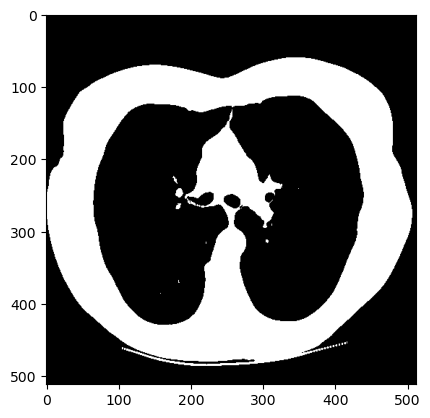

In [266]:
# Basic thresholding looking at the histograms of the images. 
# Images are in uint16 format, opencv functions of mutlti otsu and histogram qualization works on 8uint images. 
# Does the conversion lead to the information loss? Maybe not because we just want to get the mask. 
# But what if elastix wants the mask to be same type as the image?

img_array = sitk.GetArrayFromImage(sitk.ReadImage('../data/nifti/copd1_iBHCT.nii.gz'))

sur_tis = np.zeros(img_array.shape)
sur_tis[img_array > 850] = 1 # air and lungs appear as gray in the images
sur_tis[img_array > 2000] = 0 # bones and other structures -- bones appear as white in the images
#plt.imshow(sur_tis[50], cmap='gray')

# the area between 850-2000 is surrounding tissue
# the area between 0-850 is the lung tissue intesnity

# take the inverse of sur_tis to get the lung tissue
lung_t = np.zeros(img_array.shape)
lung_t[sur_tis == 1] = 0
lung_t[sur_tis == 0] = 1
# plt.imshow(lung_t[50], cmap='gray') # lung tissue = 1 surrounding = 0

k = np.zeros(img_array.shape)
k[img_array > 100] = 1 # air and lungs appear as gray in the images
k[img_array > 800] = 0
#plt.imshow(k[50], cmap='gray') # lung tissue = 1 others just line up with the surrounding tissue
